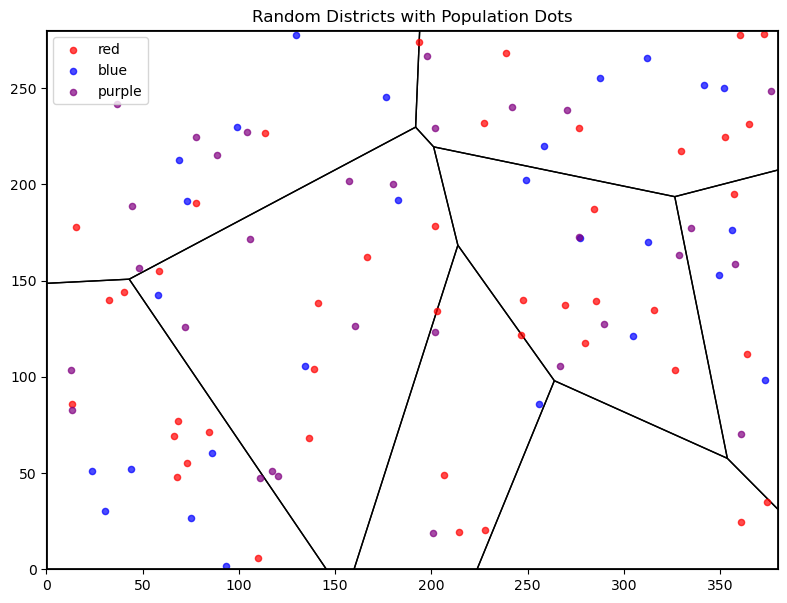

District 1: {'red': 9, 'blue': 5, 'purple': 5}
District 2: {'red': 6, 'blue': 3, 'purple': 7}
District 3: {'red': 9, 'blue': 6, 'purple': 3}
District 4: {'red': 5, 'blue': 1, 'purple': 2}
District 5: {'red': 7, 'blue': 4, 'purple': 4}
District 6: {'red': 2, 'blue': 3, 'purple': 3}
District 7: {'red': 2, 'blue': 0, 'purple': 0}
District 8: {'red': 3, 'blue': 5, 'purple': 6}


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path  # Needed for point-in-polygon checks

# --- Voronoi helpers (keep your existing functions) ---
def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]

# --- Simulation parameters ---
WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8 #congressional districts 
NUM_DOTS = 100  # Number of population dots
COLORS = ['red', 'blue', 'purple']

# --- Generate random district centers and Voronoi ---
points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# --- Generate random population dots ---
dots_x = np.random.rand(NUM_DOTS) * WIDTH
dots_y = np.random.rand(NUM_DOTS) * HEIGHT
dots_colors = np.random.choice(COLORS, NUM_DOTS)

# --- Count dots per district ---
district_counts = []  # List of dictionaries for each district

fig, ax = plt.subplots(figsize=(10, 7))

for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_counts.append({'red':0, 'blue':0, 'purple':0})
        continue
    polygon = sort_polygon(polygon)
    
    # Draw the district boundary
    ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)
    
    # Create a Path object for point-in-polygon testing
    poly_path = Path(polygon)
    mask = poly_path.contains_points(np.column_stack((dots_x, dots_y)))
    
    # Count dots by color inside this district
    counts = {color: 0 for color in COLORS}
    for color, inside in zip(dots_colors, mask):
        if inside:
            counts[color] += 1
    district_counts.append(counts)

# --- Draw the population dots ---
for color in COLORS:
    ax.scatter(dots_x[dots_colors==color], dots_y[dots_colors==color], 
               c=color, label=color, s=20, alpha=0.7)

# Colorado boundary
ax.plot([0, WIDTH, WIDTH, 0, 0], [0, 0, HEIGHT, HEIGHT, 0], color='black', linewidth=2)

ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Random Districts with Population Dots')
ax.legend()
plt.show()

# --- Print out counts for each district ---
for i, counts in enumerate(district_counts):
    print(f"District {i+1}: {counts}")
